In [108]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from skimage.color import rgb2lab
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

randomstate = 42

In [109]:
# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])


def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

In [110]:
"""
Read the data in from the csv file
"""
file_path = "colour-data.csv"

data = pd.read_csv(file_path)
X = data[['R', 'G', 'B']].values/255
y = data['Label'].values    

In [111]:
"""
Create a logistic regression model
"""
X_train, X_remainder, y_train, y_remainder = train_test_split(X,y, random_state=randomstate, test_size = 0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_remainder, y_remainder, random_state=randomstate, test_size = 0.5)
X_train.shape

(2765, 3)

Validation score:  0.6925675675675675


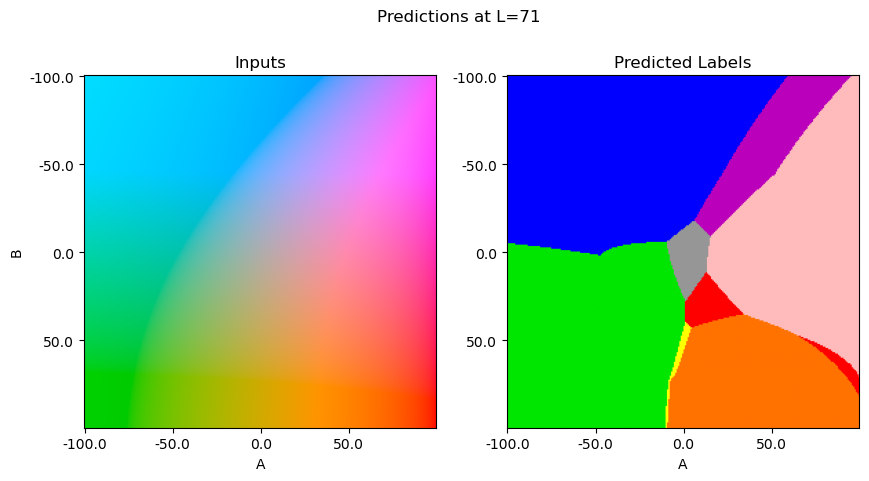

In [112]:
"""
Instantiate the model and fit it to the training data
"""

model_rgb = LogisticRegression(max_iter=10000)

"""
Train the model and print the validation score
"""
model_rgb.fit(X_train, y_train)
print("Validation score: ", model_rgb.score(X_valid, y_valid))
plot_predictions(model_rgb)

In [113]:
"""
Print the classification report
"""

y_pred = model_rgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       black       0.71      0.89      0.79        56
        blue       0.82      0.74      0.78        80
       brown       0.69      0.24      0.36        37
       green       0.72      0.93      0.81       138
        grey       0.59      0.61      0.60        49
      orange       0.71      0.28      0.40        18
        pink       0.70      0.68      0.69        41
      purple       0.72      0.79      0.75        97
         red       0.48      0.48      0.48        48
       white       0.00      0.00      0.00         3
      yellow       0.86      0.23      0.36        26

    accuracy                           0.70       593
   macro avg       0.64      0.53      0.55       593
weighted avg       0.70      0.70      0.68       593



c:\Users\leven\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leven\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leven\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
"""
Function to convert RGB to LAB
"""

def makelab(X):
    X = X.reshape(1,-1,3)
    lab = rgb2lab(X)
    return lab.reshape(-1,3)

In [115]:
model_lab = make_pipeline(FunctionTransformer(makelab), LogisticRegression(max_iter=10000))

Validation score:  0.722972972972973


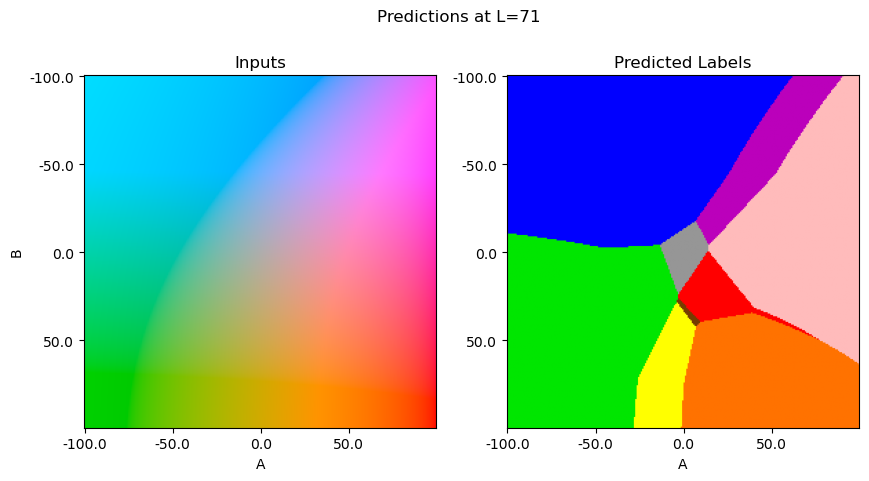

In [116]:
model_lab.fit(X_train, y_train)
print("Validation score: ", model_lab.score(X_valid, y_valid))
plot_predictions(model_lab)